In [1]:
!pip install keras

In [186]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from keras.models import Sequential
import numpy as np
import matplotlib.pyplot as plt
import os
import math
from os import listdir
from tifffile import imread, imwrite
import random
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.callbacks import EarlyStopping
import json

plt.rcParams['figure.dpi'] = 150

In [3]:
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

In [78]:
def check_data(segs):
#     print(segs[0])
    nrows = math.sqrt(len(segs))
    if nrows % 1 != 0:
        nrows = nrows - nrows % 1
    ncols = len(segs)/nrows


    fig, axs = plt.subplots( int(nrows), int(ncols))
    axs = axs.flatten()
    for i, (ax, seg) in enumerate(zip(axs, segs)):
        ax.imshow(seg)
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
#         ax.set_title(i)

    # for i, (label, ax) in enumerate(zip(lookupTable, ax)):
    #     mask = np.zeros(im.shape[:2], dtype = "uint8")
    #     mask[labels == label] = 255
    #     ax.imshow(cv2.bitwise_and(im, im, mask = mask))

#     print("--- %s seconds ---" % (time.time() - start_time))
    plt.show()


In [97]:
def augment(ims, labs):
    x = []
    y = []
    for i in range(0, len(ims)):
        r90 = np.rot90(ims[i])
        r180 = np.rot90(r90)
        r270 = np.rot90(r180)
        x.append(ims[i])
        x.append(r90)
        x.append(r180)
        x.append(r270)
        x.append(np.flipud(ims[i]))
        x.append(np.fliplr(ims[i]))
        x.append(np.flipud(r90))
        x.append(np.flipud(r180))
        for j in range(0, 8):
            y.append(labs[i])
    return [np.asarray(x), np.asarray(y)]

In [178]:
def read_segs(path):
    ims = []
    labels = []
    for classname in listdir(path):
        classpath = os.path.join(path, classname)
        print(len(classname))
        for i, file in enumerate(listdir(classpath)):
            if(i >= 91):
                break
            seg = imread(os.path.join(classpath, file))
            print(seg.shape)
#             print(seg.dtype)
#             seg = (seg/65535).astype('float32')
            ims.append(seg)
            labels.append(classname)
#         print(len(ims))
#         print(len(labels))
    print(len(ims))
    print(len(labels))
    tup = [np.asarray(ims, dtype='float32'), np.asarray(labels)]
    return tup

In [188]:
def crop(img, x, y, dim):
    xstart = int(x - (dim/2))
    ystart = int(y - (dim/2))

    xend = int(x + (dim/2))
    yend = int(y + (dim/2))

    return img[ystart:yend, xstart:xend]

In [200]:
def read_and_crop(im, path, dim):
    ims = []
    labs = []

    with open(path, 'r') as f:
        existing = json.load(f)
    for key, val in existing.items():
        for i, v in enumerate(val):
            if(i >= 90):
                break
#             print(i)
            cropped = crop(im, v[0], v[1], dim)
            ims.append(cropped)
            labs.append(key)
    return [np.array(ims), np.array(labs)]

In [183]:
path = "data/Mac_1120_UTM.tif" #"data/plantation1.tif"
rgb0 = imread(path)
rgb65 = (rgb0/65535).astype('float32')

In [205]:
# def main():
## Based on this tutorial:
##    https://medium.com/@sandy_lee/how-to-train-neural-networks-for-image-classification-part-1-21327fe1cc1

## path to labeled sets
# path = 'p3chunks/'
path = 'coords.json'

# path = 'p3chunks50/'


## 80% of data for training
train_test_split = .9

## 10% of training data for validation
validation_split = .1

# data = read_segs(path)
data = read_and_crop(rgb65, path, 32)

ims = data[0]
print(ims.dtype)
labels = data[1]
lookupTable, idx,  labels, counts = np.unique(labels, return_inverse=True, return_counts=True, return_index=True)


float32


(360, 128, 128, 4)
360
['bush' 'grass' 'road' 'sapling']
[90 90 90 90]


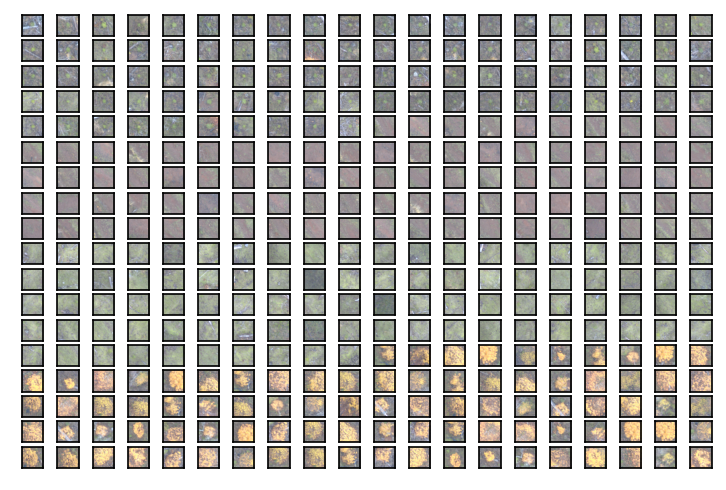

In [206]:
# tensor = tf.convert_to_tensor(ims)

print(ims.shape)
print(len(ims))
print(lookupTable)
print(counts)
check_data(ims)


In [209]:

##  Makes string labels into ints
early_stopping = EarlyStopping(
    monitor='loss', 
    patience=6, 
    min_delta=0.001, 
    mode='auto'
)

## Adds data
x, y = augment(ims, labels)
# print(x.dtype)

## Shuffles data
idx = np.random.permutation(len(x))
X,Y = x[idx], y[idx]
print(X.dtype)
print(X.shape)

# X.astype('float32')
# x.astype(int)
# print(X.dtype)



x_train, x_test= X[:int(X.shape[0]*train_test_split)], X[int(X.shape[0]*train_test_split):]
y_train, y_test = Y[:int(Y.shape[0]*train_test_split)], Y[int(Y.shape[0]*train_test_split):]

## Scales data from 0-255 to 0-1, surprisingly important for some reason
# x_train, x_test = x_train/ 256., x_test/ 256.
# print(X.shape, x_train[0].dtype)
print(Y.shape)


## Neural net, copied structure from tutorial

model = Sequential()
#add model layers
model.add(Conv2D(8, kernel_size=3, activation='relu', input_shape=(32,32,4)))
# model.add(Conv2D(8, kernel_size=3, activation='relu', input_shape=(128,128,4)))

model.add(MaxPooling2D(pool_size=(2, 2), padding='same',strides=2)),
# , padding='same' 
model.add(Conv2D(16, kernel_size=5, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same',strides=2)),
model.add(Conv2D(32, kernel_size=5, activation='relu')),
model.add(MaxPooling2D(pool_size=(2, 2), padding='same',strides=2)),
model.add(Flatten()),
# model.add(Dense(32, activation='softmax')),
model.add(Dense(len(lookupTable), activation='softmax'))


# model.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(32,32,4)))
# # model.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(50,50,4)))

# model.add(Conv2D(16, kernel_size=3, activation='relu'))
# model.add(Flatten())

# model.add(Dense(len(lookupTable), activation='softmax'))

[print(i.shape, i.dtype) for i in model.inputs]

#     model = keras.models.Sequential([keras.layers.Flatten(input_shape = [30,30,4]), #keras.layers.Flatten(input_shape = [2,2,4]
#         # keras.layers.Dense(2251, activation = 'relu' ),
#         keras.layers.Dense(500, activation = 'relu' ),
#         # keras.layers.Dense(100, activation = 'relu' ),
#         keras.layers.Dense(100, activation = 'relu' ),
#         keras.layers.Dense(100, activation = 'relu' ),
#         keras.layers.Dense(len(lookupTable), activation = 'softmax' )])
#     #

model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(), #change for tf v1 compat

#     optimizer = 'RMSprop',  #.9-.97
#     optimizer = 'Adam',     #.95-.97
    # optimizer = 'Adamax',   #.95-.97
    optimizer = 'Nadam',    #.97-.98
    metrics = ['accuracy']
)

# model.compile(loss=cc_from_logits)


# model.compile(loss=customLoss, optimizer='adam', metrics=['sparse_categorical_accuracy', 'categorical_accuracy'])

history = model.fit(x_train, y_train, epochs = 100, validation_split=validation_split,  callbacks=[early_stopping])
plot_metric(history, 'loss')

print("Evaluating: \n\n\n")
metrics = model.evaluate(x_test, y_test)

y_pred = model.predict_classes(x_test)
cm = confusion_matrix(y_true=y_test, y_pred=y_pred.round(), normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lookupTable)
disp = disp.plot(cmap='gray')
plt.show()

if metrics[1] > .99:
    model.save('model128/')

print(len(y_test))

float32
(2880, 128, 128, 4)
(2880,)
(None, 32, 32, 4) <dtype: 'float32'>
Epoch 1/100


ValueError: in user code:

    /Users/mAC/opt/anaconda3/envs/py3.8/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:805 train_function  *
        return step_function(self, iterator)
    /Users/mAC/opt/anaconda3/envs/py3.8/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /Users/mAC/opt/anaconda3/envs/py3.8/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /Users/mAC/opt/anaconda3/envs/py3.8/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /Users/mAC/opt/anaconda3/envs/py3.8/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /Users/mAC/opt/anaconda3/envs/py3.8/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:788 run_step  **
        outputs = model.train_step(data)
    /Users/mAC/opt/anaconda3/envs/py3.8/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:754 train_step
        y_pred = self(x, training=True)
    /Users/mAC/opt/anaconda3/envs/py3.8/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:1012 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /Users/mAC/opt/anaconda3/envs/py3.8/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:375 call
        return super(Sequential, self).call(inputs, training=training, mask=mask)
    /Users/mAC/opt/anaconda3/envs/py3.8/lib/python3.8/site-packages/tensorflow/python/keras/engine/functional.py:424 call
        return self._run_internal_graph(
    /Users/mAC/opt/anaconda3/envs/py3.8/lib/python3.8/site-packages/tensorflow/python/keras/engine/functional.py:560 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    /Users/mAC/opt/anaconda3/envs/py3.8/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /Users/mAC/opt/anaconda3/envs/py3.8/lib/python3.8/site-packages/tensorflow/python/keras/engine/input_spec.py:255 assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer dense_39 is incompatible with the layer: expected axis -1 of input shape to have value 32 but received input with shape (None, 5408)


In [106]:
# !jupyter nbconvert --to script cnn.ipynb